# Guided Project: Analyzing NYC High School Data
* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [10]:
correlations.sort_values(ascending=False)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

### [Top 3 +correlation features]
* SAT Writing Avg. Score                  0.987771
* SAT Critical Reading Avg. Score         0.986820
* SAT Math Avg. Score                     0.972643

### [Top 5 -correlation features]
* ell_percent                            -0.398750
* sped_percent                           -0.448170
* frl_percent                            -0.722225


In [11]:
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

* safety - sat score
  * correlation : 0.337639 ( > .25)
  * meaningful correlation

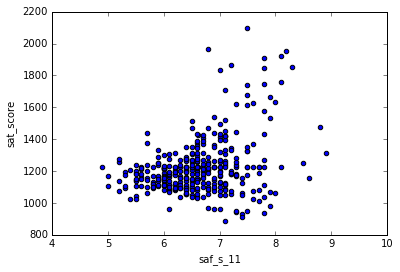

In [12]:
combined.plot(x='saf_s_11', y='sat_score', kind='scatter')

* Map out safety scores.
  * Compute the average safety score for each district.
  * Make a map that shows safety scores by district.
  * Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

In [13]:
combined.columns.tolist()

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

In [14]:
combined.groupby('school_dist')['saf_s_11'].agg(np.mean)

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
06    6.950000
07    6.800000
08    6.364697
09    6.655000
10    6.577273
11    6.186667
12    7.116667
13    6.407692
14    6.685714
15    6.177778
16    5.875000
17    6.007143
18    6.190909
19    6.150000
20    7.120000
21    6.390909
22    7.025000
23    6.233333
24    7.107692
25    6.912500
26    6.760000
27    6.390000
28    6.627273
29    6.075000
30    7.033333
31    6.530000
32    6.766667
Name: saf_s_11, dtype: float64

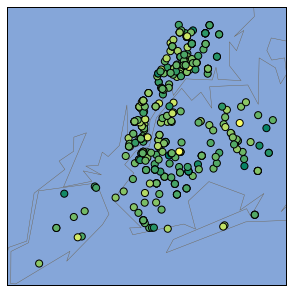

In [68]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
plt.figure(figsize=(5,5))
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined.lon.tolist()
latitudes = combined.lat.tolist()

m.scatter(longitudes, latitudes, s=50,\
          zorder=2, latlon = True,\
          c = combined["saf_s_11"],\
          cmap = "summer")
          


There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

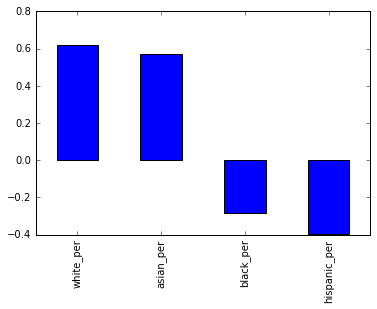

In [16]:
# Investigate racial differences in SAT scores.
# Make a bar plot of the correlations between the columns above and sat_score.

race_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

race_corr = combined[race_per+['sat_score']].corr()
race_corr.iloc[-1, :-1].plot(kind='bar')

* Explore schools with low SAT scores and high values for hispanic_per.
  * Make a scatter plot of hispanic_per vs. sat_score.

In [17]:
# mean SAT score
combined.sat_score.mean()

1223.4388059701494

In [18]:
hispanic_over_50 = combined[(combined.sat_score < (combined.sat_score.mean())) &\
                    (combined.hispanic_per > 50)]\
                    .sort_values(by='sat_score', ascending=False)
    
hispanic_over_50.head(3)

DBN                            SCHOOL NAME Num of SAT Test Takers  \
145  10X434        BELMONT PREPARATORY HIGH SCHOOL                     51   
69   04M555          CENTRAL PARK EAST HIGH SCHOOL                     73   
129  09X413  BRONX HIGH SCHOOL FOR MEDICAL SCIENCE                     64   

     SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
145                            404.0                418.0   
69                             405.0                421.0   
129                            400.0                419.0   

     SAT Writing Avg. Score  sat_score                     SchoolName  \
145                   400.0     1222.0  BELMONT PREPARATORY HIGH SCHL   
69                    395.0     1221.0         CENTRAL PARK EAST H.S.   
129                   402.0     1221.0                              0   

     AP Test Takers   Total Exams Taken     ...      priority05 priority06  \
145        31.000000          45.000000     ...               0          0   
69        129.028846         197.038462     ...               0          0   
129       129.028846         197.038462     ...               0          0   

    priority07 priority08  priority09 priority10  \
145          0          0           0          0   
69           0          0           0          0   
129          0          0           0          0   

                                            Location 1        lat        lon  \
145  500 East Fordham Road\nBronx, NY 10458\n(40.86...  40.860012 -73.888230   
69   1573 Madison Avenue\nNew York, NY 10029\n(40.7...  40.793679 -73.949416   
129  240 East 172 Street\nBronx, NY 10457\n(40.8403...  40.840373 -73.910838   

    school_dist  
145          10  
69           04  
129          09  

[3 rows x 160 columns]

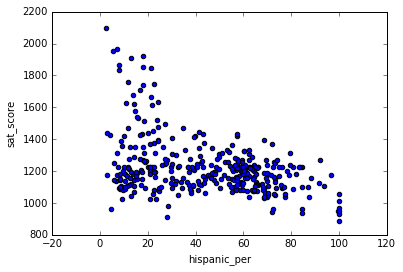

In [19]:
combined.plot(x='hispanic_per', y='sat_score', kind='scatter')

Research any schools with a hispanic_per greater than 95%.
* Find the school names in the data.
* Use Wikipedia and Google to research the schools by name.
* Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [20]:
hispanic_over_95 = combined[combined.hispanic_per > 95]\
                .sort_values(by='sat_score', ascending=False)

In [21]:
print(hispanic_over_95.sat_score.mean())
print(combined.sat_score.mean())

992.375
1223.43880597


Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
* Find the school names in the data.
* Use Wikipedia and Google to research the schools by name.
* Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [22]:
his_under_10_and_sat_1800 = combined[(combined.hispanic_per < 10) \
                             & (combined.sat_score > 1800)]

his_under_10_and_sat_1800.head(3)

DBN                     SCHOOL NAME Num of SAT Test Takers  \
37   02M475          STUYVESANT HIGH SCHOOL                    832   
151  10X445    BRONX HIGH SCHOOL OF SCIENCE                    731   
187  13K430  BROOKLYN TECHNICAL HIGH SCHOOL                   1277   

     SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
37                             679.0                735.0   
151                            632.0                688.0   
187                            587.0                659.0   

     SAT Writing Avg. Score  sat_score             SchoolName  \
37                    682.0     2096.0          STUYVESANT HS   
151                   649.0     1969.0    BRONX HS OF SCIENCE   
187                   587.0     1833.0  BROOKLYN TECHNICAL HS   

     AP Test Takers   Total Exams Taken     ...      priority05 priority06  \
37            1510.0             2819.0     ...               0          0   
151           1190.0             2435.0     ...               0          0   
187           2117.0             3692.0     ...               0          0   

    priority07 priority08  priority09 priority10  \
37           0          0           0          0   
151          0          0           0          0   
187          0          0           0          0   

                                            Location 1        lat        lon  \
37   345 Chambers Street\nNew York, NY 10282\n(40.7...  40.717746 -74.014049   
151  75 West 205 Street\nBronx, NY 10468\n(40.87705...  40.877056 -73.889780   
187  29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...  40.688107 -73.976745   

    school_dist  
37           02  
151          10  
187          13  

[3 rows x 160 columns]

In [23]:
his_under_10_and_sat_1800[['SCHOOL NAME', 'school_dist','lon', 'lat']]

SCHOOL NAME school_dist        lon  \
37                              STUYVESANT HIGH SCHOOL          02 -74.014049   
151                       BRONX HIGH SCHOOL OF SCIENCE          10 -73.889780   
187                     BROOKLYN TECHNICAL HIGH SCHOOL          13 -73.976745   
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...          28 -73.798154   
356                STATEN ISLAND TECHNICAL HIGH SCHOOL          31 -74.115362   

           lat  
37   40.717746  
151  40.877056  
187  40.688107  
327  40.700999  
356  40.567913

In [24]:
hispanic_over_95[['SCHOOL NAME', 'school_dist', 'lon', 'lat']]

SCHOOL NAME school_dist        lon  \
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL          06 -73.930807   
44                       MANHATTAN BRIDGES HIGH SCHOOL          02 -73.992517   
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...          06 -73.938371   
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE          12 -73.878823   
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY          09 -73.916088   
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL          24 -73.870575   
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS          10 -73.898163   
253                          MULTICULTURAL HIGH SCHOOL          19 -73.868426   

           lat  
82   40.848879  
44   40.765027  
89   40.838032  
176  40.831366  
125  40.849102  
286  40.743303  
141  40.870377  
253  40.691144

### Plotting in Basemap

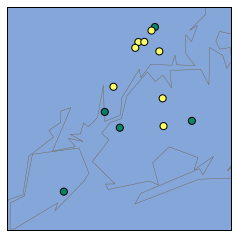

In [25]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = his_under_10_and_sat_1800.lon.tolist() +\
             hispanic_over_95.lon.tolist()
latitudes = his_under_10_and_sat_1800.lat.tolist() +\
             hispanic_over_95.lat.tolist()

hispanic_per_combined = his_under_10_and_sat_1800.hispanic_per.tolist() +\
             hispanic_over_95.hispanic_per.tolist()
    
m.scatter(longitudes, latitudes, s=50,\
          zorder=2, latlon = True,\
          c = hispanic_per_combined,\
          cmap = "summer")

plt.figure(figsize=(10,10))
plt.show()

There are two columns that indicate the percentage of each gender at a school:

* male_per
* female_per

We can plot out the correlations between each percentage and sat_score.

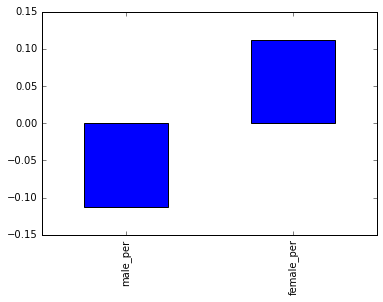

In [26]:
combined[['male_per', 'female_per', 'sat_score']].corr().iloc[-1, :-1].plot(kind='bar')

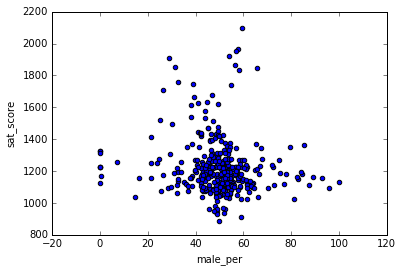

In [27]:
combined.plot(x='male_per', y='sat_score',\
             kind = 'scatter')

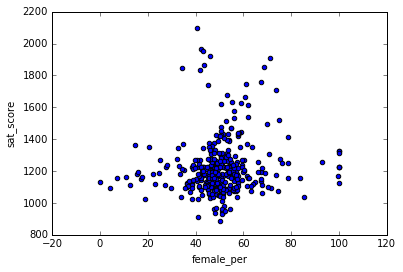

In [28]:
combined.plot(x='female_per', y='sat_score',\
             kind = 'scatter')

Investigate schools with high SAT scores and a high female_per.
* Make a scatter plot of female_per vs. sat_score.
  
### >>> strong + correlation

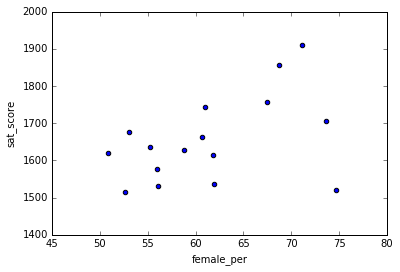

In [29]:
combined_high_scored_fem =\
        combined[(combined.female_per > 50) &\
                (combined.sat_score > 1500)]
    
combined_high_scored_fem.plot(\
                             x='female_per',\
                              y='sat_score',\
                              kind = 'scatter'
                             )

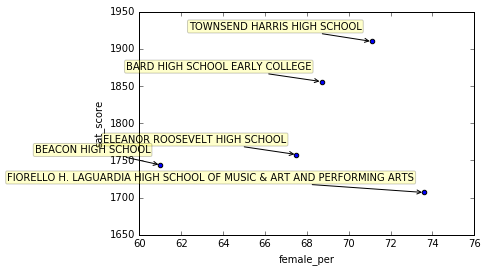

In [30]:
combined_high_scored_fem2 =\
        combined[(combined.female_per > 60) &\
                (combined.sat_score > 1700)]
    
combined_high_scored_fem2.plot(\
                             x='female_per',\
                              y='sat_score',\
                               kind = 'scatter'
                             )

labels = combined_high_scored_fem2['SCHOOL NAME']

for label, x, y in zip(labels, \
                       combined_high_scored_fem2.female_per, \
                       combined_high_scored_fem2.sat_score):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.15', fc='yellow', alpha=0.2),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [31]:
combined_high_scored_fem2['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Calculate the percentage of students in each school that took an AP exam.
* Divide the AP Test Takers column by the total_enrollment column.
  * The column name AP Test Takers has a space at the end -- don't forget to add it!
* Assign the result to the ap_per column.

In [32]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

Investigate the relationship between AP scores and SAT scores.
* Make a scatter plot of ap_per vs. sat_score.
* What does the scatter plot show? Record any interesting observations in a Markdown cell.

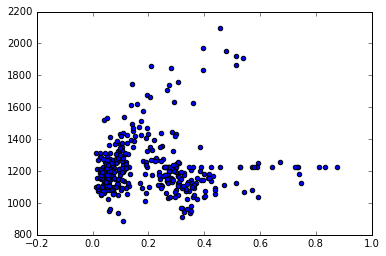

In [33]:
plt.scatter(combined.ap_per, combined.sat_score)

# Here are some potential next steps:

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
  * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.

correlation : 0.38101433081


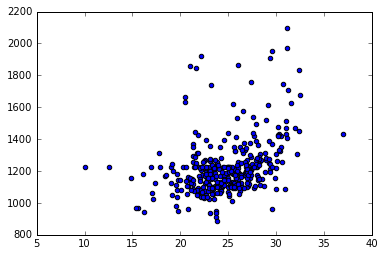

In [34]:
# Determing wheter there's a correlation between class size and SAT scores

plt.scatter(combined['AVERAGE CLASS SIZE'],\
           combined['sat_score'])

print('correlation :',\
      combined[['AVERAGE CLASS SIZE', 'sat_score']].corr().iloc[0,1])

### Figuring out which neighborhoods have the best schools

In [107]:
dist_by_score = combined.groupby('school_dist')[['sat_score', 'school_dist']].mean()\
                .sort_values(by='sat_score')

dist_by_score_dict = dist_by_score.to_dict()
dist_by_score_dict['sat_score']


{'01': 1354.5,
 '02': 1295.6381840796021,
 '03': 1293.4430348258709,
 '04': 1224.1428571428571,
 '05': 1285.0626865671641,
 '06': 1164.6438805970149,
 '07': 1128.8461538461538,
 '08': 1159.6651289009499,
 '09': 1131.9719402985074,
 '10': 1222.2272727272727,
 '11': 1165.0,
 '12': 1101.8231343283583,
 '13': 1237.1876004592423,
 '14': 1179.4599147121535,
 '15': 1190.6043117744609,
 '16': 1120.1097014925374,
 '17': 1161.4285714285713,
 '18': 1118.0,
 '19': 1103.8333333333333,
 '20': 1273.6877611940299,
 '21': 1206.3126187245589,
 '22': 1450.5,
 '23': 1157.3333333333333,
 '24': 1242.0,
 '25': 1357.0,
 '26': 1377.5999999999999,
 '27': 1224.3,
 '28': 1347.8469470827679,
 '29': 1181.9298507462686,
 '30': 1326.3820895522388,
 '31': 1382.5,
 '32': 1119.5}

In [108]:
combined['dist_scored_by_sat'] = combined['school_dist'].map(dist_by_score_dict['sat_score'])


In [109]:
combined['dist_scored_by_sat']

0      1354.500000
1      1354.500000
2      1354.500000
3      1354.500000
4      1354.500000
5      1354.500000
6      1295.638184
7      1295.638184
8      1295.638184
9      1295.638184
10     1295.638184
11     1295.638184
12     1295.638184
13     1295.638184
14     1295.638184
15     1295.638184
16     1295.638184
17     1295.638184
18     1295.638184
19     1295.638184
20     1295.638184
21     1295.638184
22     1295.638184
23     1295.638184
24     1295.638184
25     1295.638184
26     1295.638184
27     1295.638184
28     1295.638184
29     1295.638184
          ...     
333    1181.929851
334    1181.929851
335    1181.929851
336    1181.929851
337    1181.929851
338    1326.382090
339    1326.382090
340    1326.382090
341    1326.382090
342    1326.382090
343    1326.382090
344    1326.382090
345    1326.382090
346    1326.382090
347    1382.500000
348    1382.500000
349    1382.500000
350    1382.500000
351    1382.500000
352    1382.500000
353    1382.500000
354    1382.

In [111]:
combined[['dist_scored_by_sat','lat', 'lon']].sort_values(by='dist_scored_by_sat')


dist_scored_by_sat        lat        lon
181         1101.823134  40.841805 -73.875418
173         1101.823134  40.827764 -73.900387
174         1101.823134  40.836953 -73.887962
175         1101.823134  40.825226 -73.893950
176         1101.823134  40.831366 -73.878823
177         1101.823134  40.831365 -73.878345
178         1101.823134  40.827764 -73.900387
179         1101.823134  40.831366 -73.878823
180         1101.823134  40.830807 -73.886021
182         1101.823134  40.831366 -73.878823
172         1101.823134  40.835937 -73.890468
171         1101.823134  40.825226 -73.893950
252         1103.833333  40.667553 -73.894801
251         1103.833333  40.667553 -73.894801
250         1103.833333  40.667553 -73.894801
249         1103.833333  40.667553 -73.894801
248         1103.833333  40.660637 -73.886342
259         1103.833333  40.670683 -73.874217
258         1103.833333  40.674224 -73.896454
254         1103.833333  40.678231 -73.875973
257         1103.833333  40.691144 -73.868426
256         1103.833333  40.691144 -73.868426
255         1103.833333  40.691144 -73.868426
253         1103.833333  40.691144 -73.868426
237         1118.000000  40.648664 -73.921899
238         1118.000000  40.632627 -73.917798
239         1118.000000  40.632627 -73.917798
241         1118.000000  40.632627 -73.917798
242         1118.000000  40.658457 -73.929033
243         1118.000000  40.641844 -73.898687
..                  ...        ...        ...
4           1354.500000  40.718725 -73.979426
0           1354.500000  40.713764 -73.985260
5           1354.500000  40.718962 -73.976066
299         1357.000000  40.765123 -73.790060
296         1357.000000  40.724523 -73.809428
303         1357.000000  40.725603 -73.810721
302         1357.000000  40.734408 -73.821417
301         1357.000000  40.765243 -73.827855
300         1357.000000  40.738697 -73.824795
297         1357.000000  40.760414 -73.818376
298         1357.000000  40.749303 -73.821808
308         1377.600000  40.744904 -73.726910
307         1377.600000  40.771867 -73.780387
304         1377.600000  40.752392 -73.756083
306         1377.600000  40.732817 -73.739650
305         1377.600000  40.740556 -73.792848
356         1382.500000  40.567913 -74.115362
355         1382.500000  40.642741 -74.078711
353         1382.500000  40.528229 -74.192154
354         1382.500000  40.598652 -74.123105
351         1382.500000  40.633843 -74.142107
350         1382.500000  40.569182 -74.107301
349         1382.500000  40.607453 -74.101482
347         1382.500000  40.582022 -74.157848
352         1382.500000  40.644745 -74.081341
348         1382.500000  40.582022 -74.157848
279         1450.500000  40.649201 -73.971695
278         1450.500000  40.580847 -73.936089
277         1450.500000  40.609758 -73.948452
276         1450.500000  40.633335 -73.952916

[363 rows x 3 columns]

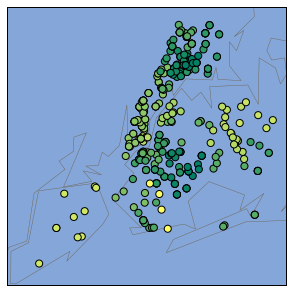

In [112]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
plt.figure(figsize=(5,5))
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined.lon.tolist()
latitudes = combined.lat.tolist()

m.scatter(longitudes, latitudes, s=50,\
          zorder=2, latlon = True,\
          c = combined["dist_scored_by_sat"],\
          cmap = "summer")
          


## School survey features
FEATURE|MEANING
:---:|:---:
dbn	School|identification code (district borough number)
sch_type|School type (Elementary, Middle, High, etc)
location|School name
enrollment|Enrollment size
borough|Borough
principal|Principal name
studentsurvey|Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12.
rr_s|Student Response Rate
rr_t|Teacher Response Rate
rr_p|Parent Response Rate
N_s|Number of student respondents
N_t|Number of teacher respondents
N_p|Number of parent respondents
nr_s|Number of eligible students
nr_t|Number of eligible teachers
nr_p|Number of eligible parents
saf_p_10|Safety and Respect score based on parent responses
com_p_10|Communication score based on parent responses
eng_p_10|Engagement score based on parent responses
aca_p_10|Academic expectations score based on parent responses
saf_t_10|Safety and Respect score based on teacher responses
com_t_10|Communication score based on teacher responses
eng_t_10|Engagement score based on teacher responses
aca_t_10|Academic expectations score based on teacher responses
saf_s_10|Safety and Respect score based on student responses
com_s_10|Communication score based on student responses
eng_s_10|Engagement score based on student responses
aca_s_10|Academic expectations score based on student responses
saf_tot_10|Safety and Respect total score
com_tot_10|Communication total score
eng_tot_10|Engagement total score
aca_tot_10|Academic Expectations total score

In [40]:
survey_cols = [ 'rr_s','rr_t', 'rr_p', 'N_s', 'N_t',
 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11',
 'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11',
 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']

In [42]:
combined.rr_s

0      89.0
1      84.0
2       0.0
3      90.0
4      98.0
5      98.0
6      72.0
7      86.0
8      48.0
9      61.0
10     96.0
11     92.0
12     83.0
13     82.0
14     78.0
15     86.0
16     96.0
17     89.0
18     83.0
19     92.0
20     84.0
21     81.0
22     86.0
23     85.0
24     93.0
25     99.0
26     85.0
27     95.0
28     79.0
29     93.0
       ... 
333    86.0
334    83.0
335    95.0
336    87.0
337    75.0
338    99.0
339    96.0
340    79.0
341    70.0
342    88.0
343    91.0
344    85.0
345    96.0
346    97.0
347    94.0
348    95.0
349    96.0
350    90.0
351    74.0
352    77.0
353    85.0
354    92.0
355    87.0
356    99.0
357    87.0
358    80.0
359    73.0
360    59.0
361    88.0
362    67.0
Name: rr_s, dtype: float64

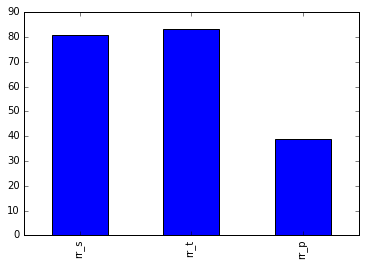

In [44]:
# reponse rate
combined[['rr_s', 'rr_t', 'rr_p']].mean().plot(kind='bar')

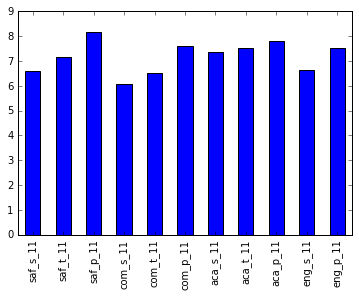

In [58]:
# eng_t_10 --- No data, unavailabe to compare responses regarding english.
response_detail_scores = ['saf_s_11',  'saf_t_11', 'saf_p_11', 
 'com_s_11', 'com_t_11', 'com_p_11', 'aca_s_11',  'aca_t_11', 'aca_p_11',
 'eng_s_11', 'eng_p_11']

combined[response_detail_scores].mean().plot(kind='bar')

### Interesting points
#### safety&respect, academic, communication
  * Students tend to have the most negative opinions on the schools in all kinds of persepctives
  * Parents tend to have the most optimistic opinions on the schools in all kinds of persepctives
  * Teachers seem to have the most balanced and variated opinions
  
#### (teacher) engagement
  * Parents tend to be more satisfied with the service from teachers than students.

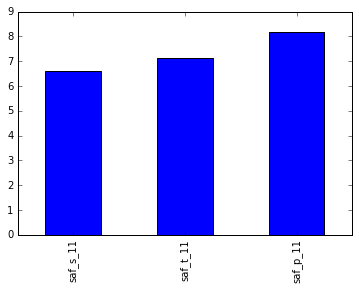

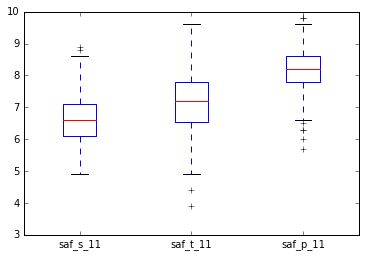

In [56]:
# safety and respect score by responser (student, teacher, parent)
combined[['saf_s_11', 'saf_t_11', 'saf_p_11']].mean().plot(kind='bar')
combined[['saf_s_11', 'saf_t_11', 'saf_p_11']].plot(kind='box')
plt.show()

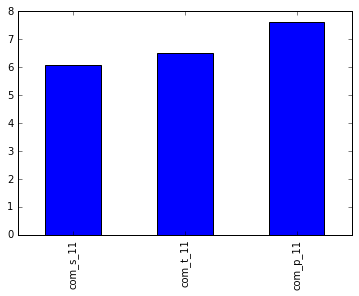

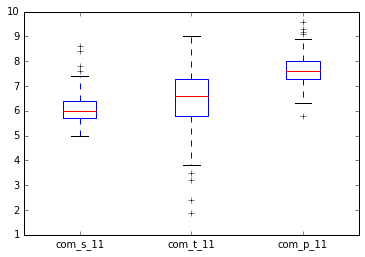

In [59]:
combined[['com_s_11', 'com_t_11', 'com_p_11']].mean().plot(kind='bar')
combined[['com_s_11', 'com_t_11', 'com_p_11']].plot(kind='box')
plt.show()

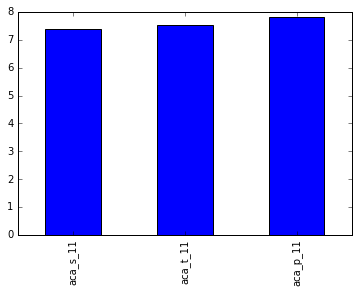

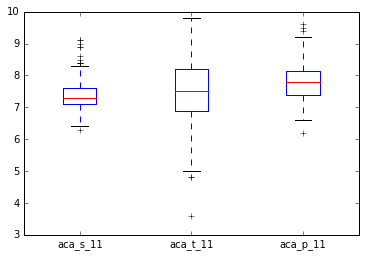

In [60]:
combined[['aca_s_11', 'aca_t_11', 'aca_p_11']].mean().plot(kind='bar')
combined[['aca_s_11', 'aca_t_11', 'aca_p_11']].plot(kind='box')
plt.show()

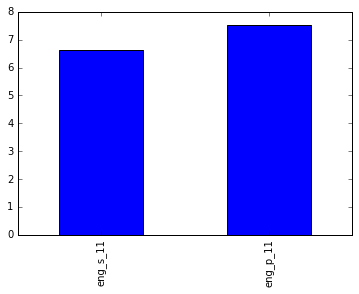

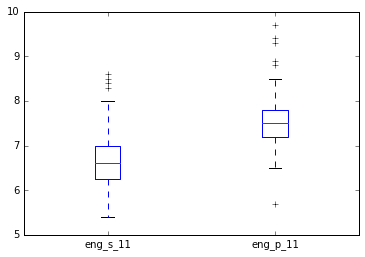

In [61]:
combined[['eng_s_11', 'eng_p_11']].mean().plot(kind='bar')
combined[['eng_s_11', 'eng_p_11']].plot(kind='box')
plt.show()

# School evaluation via multiple features
* Using Top 10 features by + correlation with sat_score

In [95]:
school_score_cols = correlations.sort_values(ascending=False)[:10].index.tolist()

In [101]:
school_score_df = combined[school_score_cols]
school_score_df.head(3)

sat_score  SAT Writing Avg. Score  SAT Critical Reading Avg. Score  \
0     1122.0                   363.0                            355.0   
1     1172.0                   366.0                            383.0   
2     1149.0                   370.0                            377.0   

   SAT Math Avg. Score  white_per  asian_per  AP Test Takers   \
0                404.0        1.7       14.0       129.028846   
1                423.0        2.3       29.2        39.000000   
2                402.0       10.4        9.7        19.000000   

   Total Exams Taken  asian_num  Number of Exams with scores 3 4 or 5  
0         197.038462         59                                153.45  
1          49.000000        115                                 10.00  
2          21.000000         58                                153.45

In [102]:
def regularize(col):
    return (col - col.mean()) / col.std()

school_score_reg = school_score_df.apply(regularize)
school_score_reg

sat_score  SAT Writing Avg. Score  SAT Critical Reading Avg. Score  \
0    -0.569165               -0.619437                        -0.854452   
1    -0.288619               -0.568750                        -0.367380   
2    -0.417670               -0.501168                        -0.471753   
3    -0.092237               -0.264630                        -0.245613   
4     2.230686                2.117646                         2.050580   
5     3.549253                3.857890                         3.824911   
6    -0.232510               -0.213943                        -0.158636   
7    -0.165179               -0.129465                         0.084900   
8    -0.378394               -0.366004                        -0.176031   
9    -0.630886               -0.636333                        -0.523939   
10    0.390303                0.546357                         0.328436   
11    0.255640                0.276028                        -0.002077   
12   -0.967541               -1.008035                        -0.889242   
13   -0.423281               -0.247734                        -0.506544   
14   -0.131513                0.090177                        -0.019472   
15   -0.541111               -0.264630                        -0.541334   
16   -0.266176               -0.095674                        -0.228217   
17    1.187054                1.340449                         1.198205   
18    0.000000                0.000000                         0.000000   
19    0.000000                0.000000                         0.000000   
20    0.000000                0.000000                         0.000000   
21    1.097279                1.036329                         1.059042   
22    1.675204                2.083855                         1.824440   
23    1.983805                1.999377                         1.598300   
24    2.544897                2.540035                         2.311511   
25    1.097279                1.002538                         1.111228   
26    2.999382                3.249649                         2.920350   
27    2.191409                2.252810                         2.154952   
28   -0.299841               -0.315317                        -0.245613   
29    0.463245                0.478775                         0.432808   
..         ...                     ...                              ...   
333   0.356637                0.411193                         0.554576   
334  -0.692606               -0.619437                        -0.593521   
335   0.000000                0.000000                         0.000000   
336  -0.019295               -0.095674                        -0.071659   
337  -0.406449               -0.382899                        -0.193426   
338   0.000000                0.000000                         0.000000   
339   0.177087                0.090177                         0.102295   
340   0.289306                0.208446                         0.171877   
341  -0.030517               -0.078779                        -0.019472   
342   1.518098                1.593883                         1.737463   
343   0.087313               -0.028092                         0.050109   
344  -0.541111               -1.193887                        -1.411104   
345   1.383436                1.543196                         1.441741   
346   2.314849                2.438662                         2.085371   
347   0.726958                0.850478                         0.832902   
348  -0.159568               -0.247734                        -0.106449   
349   1.136555                1.120807                         1.180810   
350   0.300528                0.276028                         0.345831   
351   0.311750                0.292924                         0.345831   
352   0.435190                0.495671                         0.571971   
353   1.091668                1.188389                         1.006856   
354   0.923340                

In [109]:
school_scores = school_score_reg.apply(sum, axis=1)
combined['complex_score'] = school_scores

top10_school_idx = school_scores.sort_values(ascending=False)[:10].index

combined[['school_name', 'complex_score']].iloc[top10_school_idx]

school_name  complex_score
187                     Brooklyn Technical High School      59.678972
37                              Stuyvesant High School      57.703600
151                       Bronx High School of Science      48.132009
356                Staten Island Technical High School      29.293923
302                        Townsend Harris High School      27.520711
61   Fiorello H. LaGuardia High School of Music & A...      24.569694
304                    Benjamin N. Cardozo High School      22.942459
305                          Francis Lewis High School      22.275352
327  Queens High School for the Sciences at York Co...      20.449578
276                                Midwood High School      20.283395